В качестве датасета мы выбрали «Breast Cancer Wisconsin (Diagnostic)» («Рак молочной железы в Висконсине (диагностика)»). Признаки вычисляются на основе оцифрованного изображения тонкоигольной аспирационной биопсии (FNA) опухоли молочной железы. Они описывают характеристики ядер клеток, присутствующих на изображении.

Классифицируются данные по диагнозу – опухоль может быть доброкачественной (Benign – B) и злокачественной (Malignant – M).

Для каждого клеточного ядра вычисляются десять действительных характеристик:

radius – расстояние от центра до точек контура (среднее)
texture – стандартное отклонение уровней серого
perimeter – периметр
area – площадь
smoothness – локальные колебания радиуса (гладкость)
compactness – компактность, обычно (perimeter^2)/area-1.0
concavity – степень вогнутости (насколько контур имеет вогнутые части)
concave points – количество вогнутых сегментов контура
symmetry – симметрия
fractal dimension – фрактальная размерность
Среднее значение, стандартная ошибка и «наихудшее» (то есть наибольшее – среднее из трёх самых больших значений) были вычислены для каждого признака на изображении, в результате чего получилось 30 признаков.

Например, поле 3 соответствует среднему радиусу (Mean Radius), поле 13 – стандартной ошибке радиуса (Radius SE), а поле 23 – наибольшему радиусу (Worst Radius).

Загрузим данные:

In [532]:
import pandas as pd

file_path = "data.csv"
df_orig = pd.read_csv(file_path)
df_orig = df_orig.drop(columns=['Unnamed: 32', 'id'])
df = df_orig.drop(columns=["diagnosis"])
df.info()

df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   radius_mean              569 non-null    float64
 1   texture_mean             569 non-null    float64
 2   perimeter_mean           569 non-null    float64
 3   area_mean                569 non-null    float64
 4   smoothness_mean          569 non-null    float64
 5   compactness_mean         569 non-null    float64
 6   concavity_mean           569 non-null    float64
 7   concave points_mean      569 non-null    float64
 8   symmetry_mean            569 non-null    float64
 9   fractal_dimension_mean   569 non-null    float64
 10  radius_se                569 non-null    float64
 11  texture_se               569 non-null    float64
 12  perimeter_se             569 non-null    float64
 13  area_se                  569 non-null    float64
 14  smoothness_se            5

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


Проведем дескриптивный анализ:

In [533]:
df.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


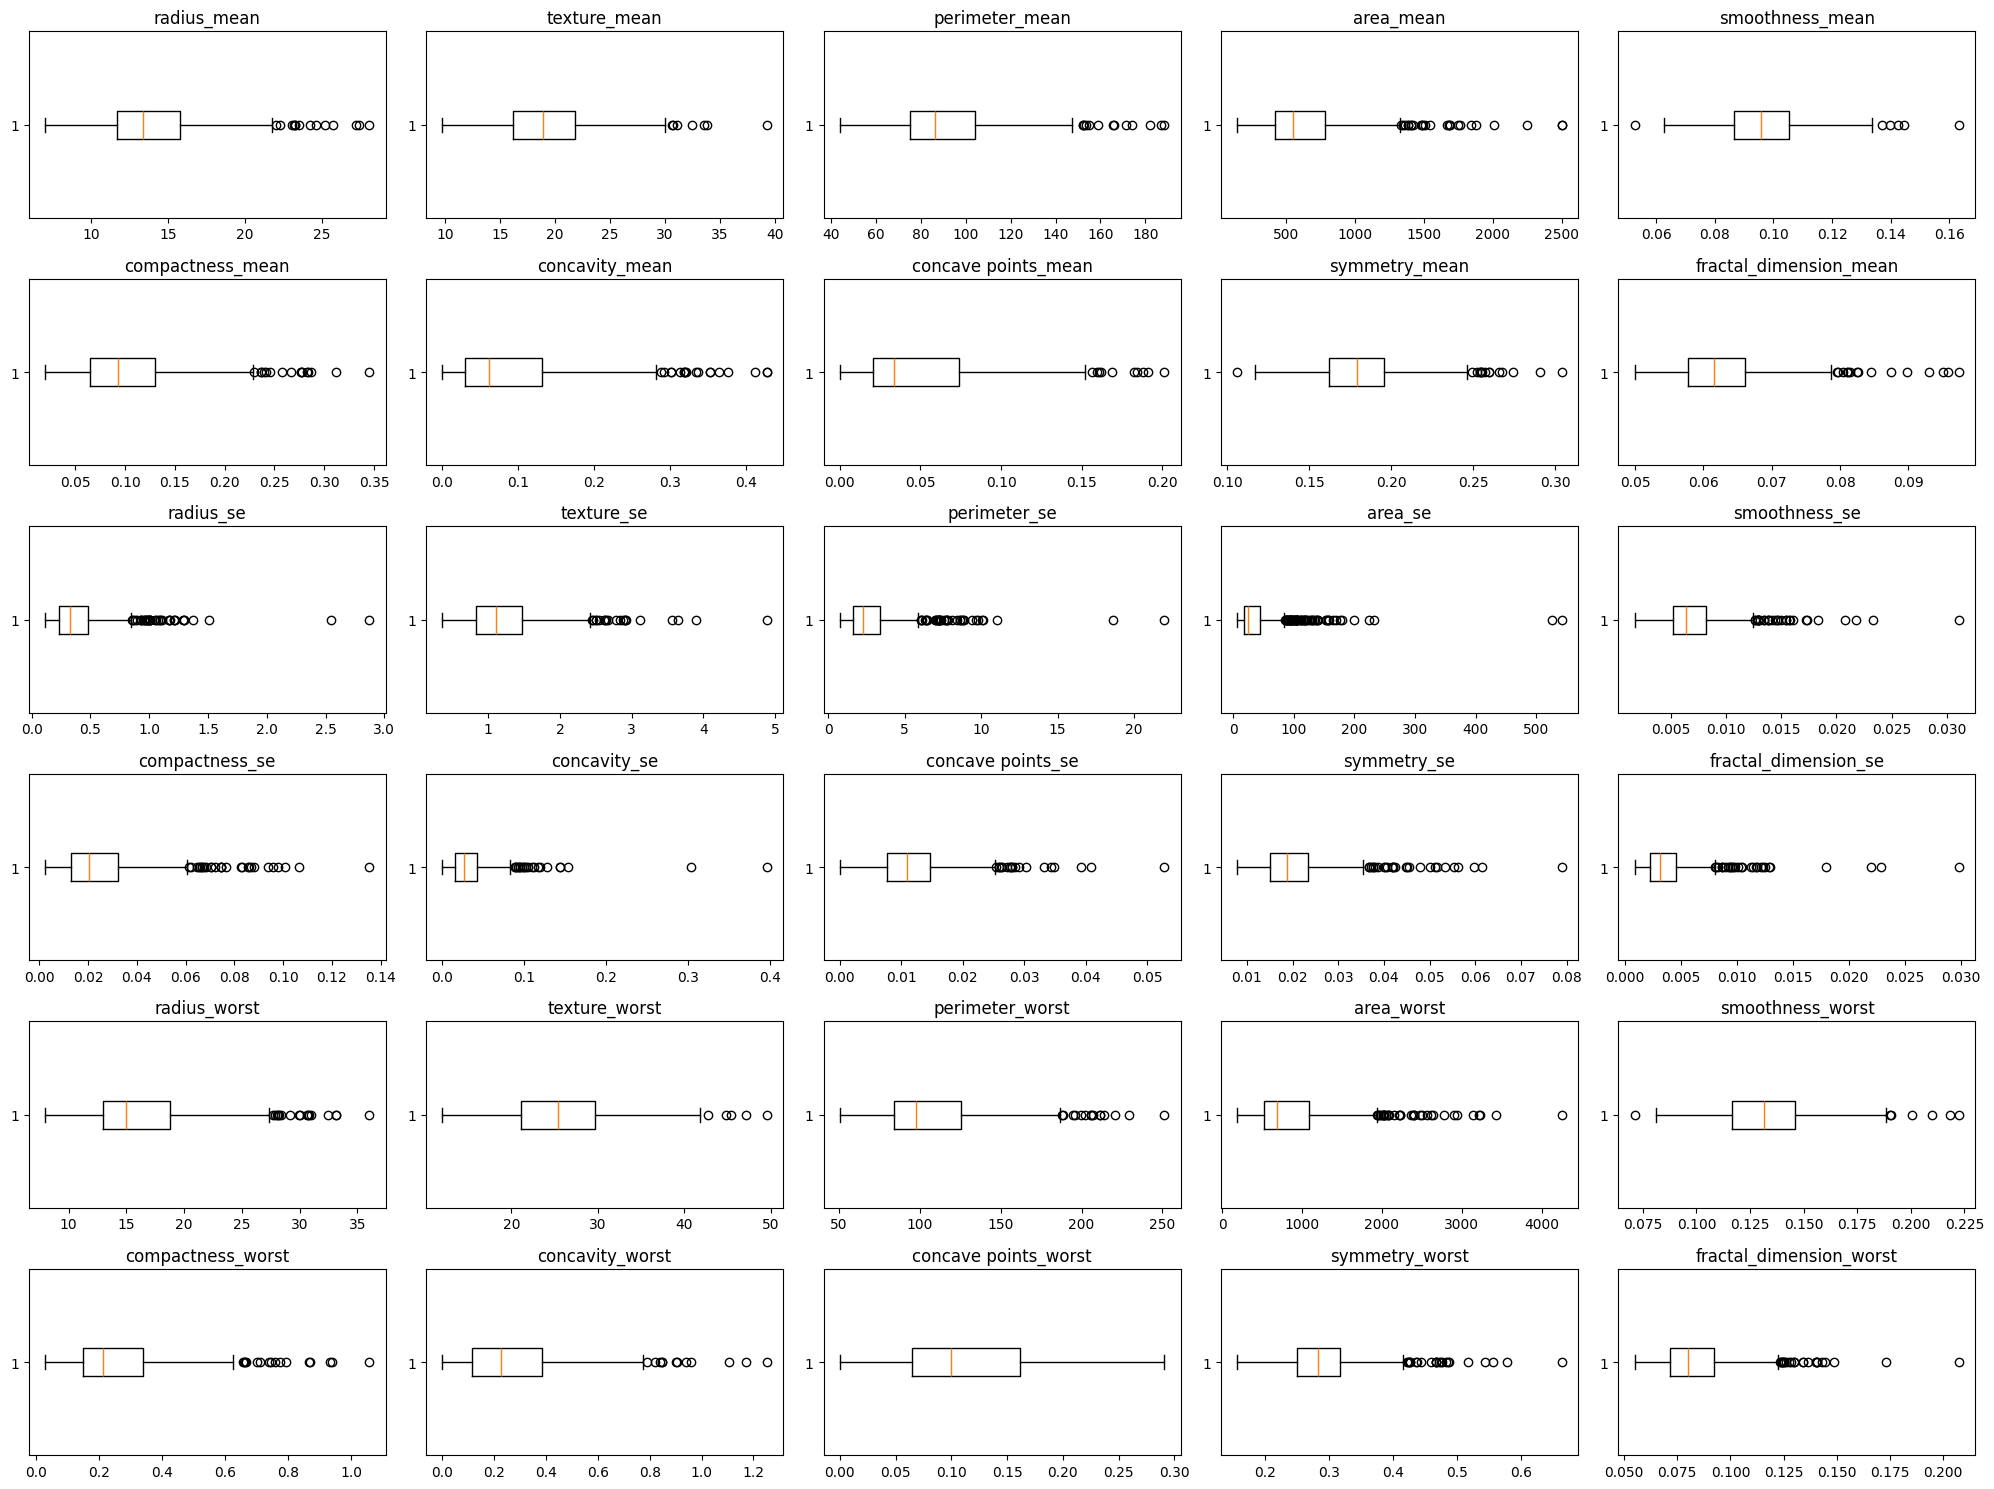

In [534]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 15))

for i, col in enumerate(df.columns):
    plt.subplot(6, 5, i + 1)
    plt.boxplot(df[col], vert=False)
    plt.title(col)

plt.tight_layout()
plt.show()


На boxplot действительно наблюдается большое количество значений, выходящих за пределы 1.5 IQR. Однако данные выбросы соответствуют реальным биологическим особенностям злокачественных опухолей и отражают клиническую вариативность. Удалять их некорректно, так как это приведёт к потере важной информации и ухудшит качество кластеризации. Вместо удаления выбросов применяется стандартизация признаков, что снижает их влияние на методы, чувствительные к масштабу (например, K-means).

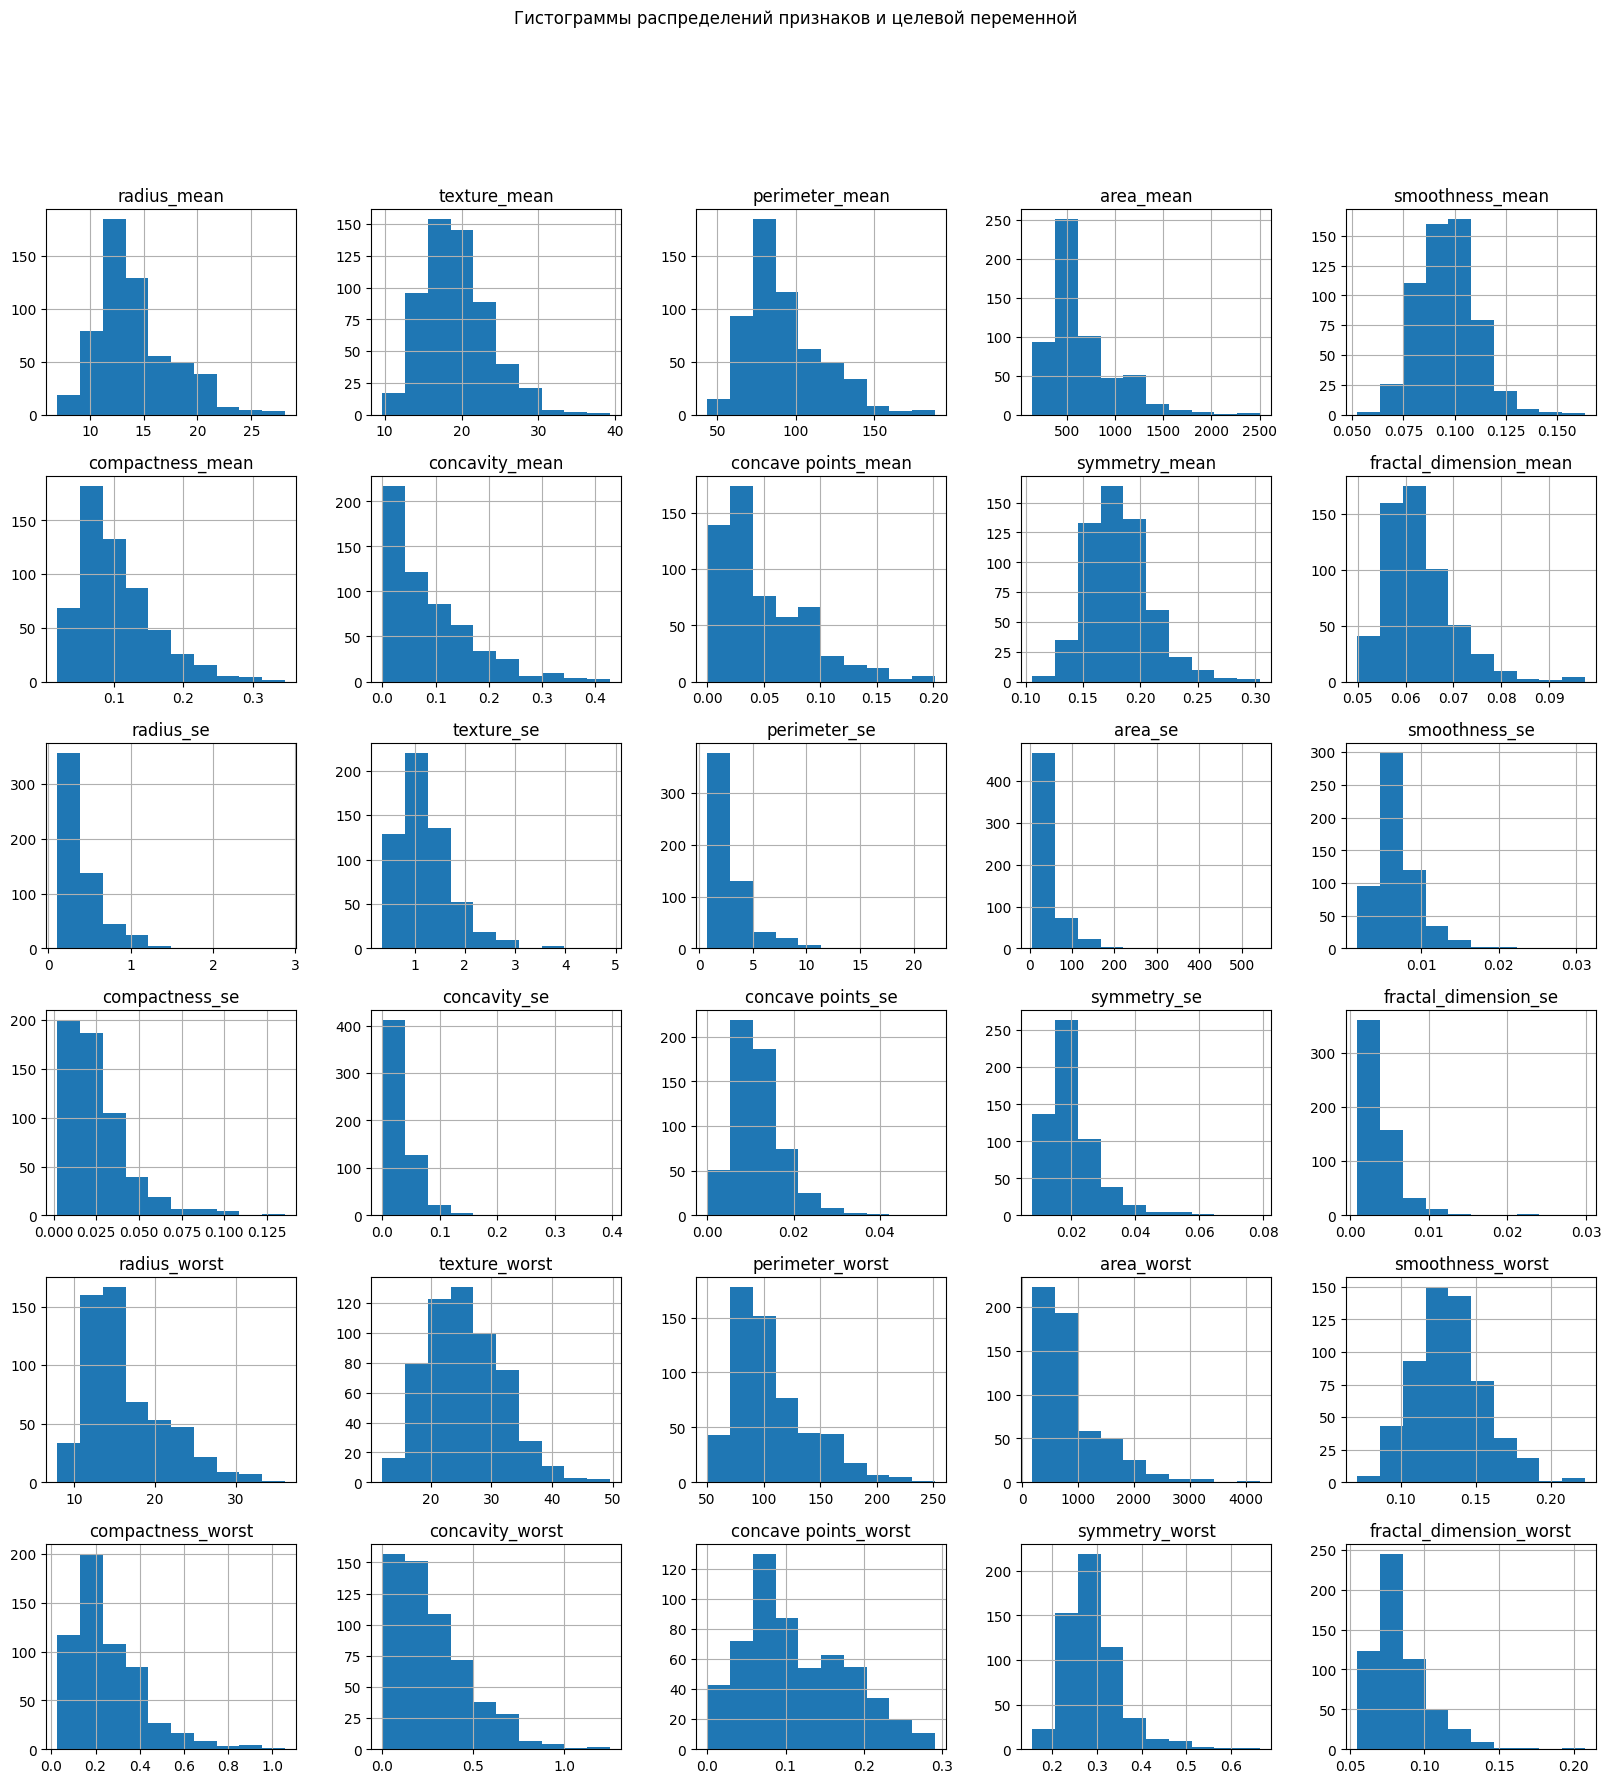

In [535]:

df.hist(bins=10, figsize=(20, 20))
plt.suptitle("Гистограммы распределений признаков и целевой переменной")
plt.show()

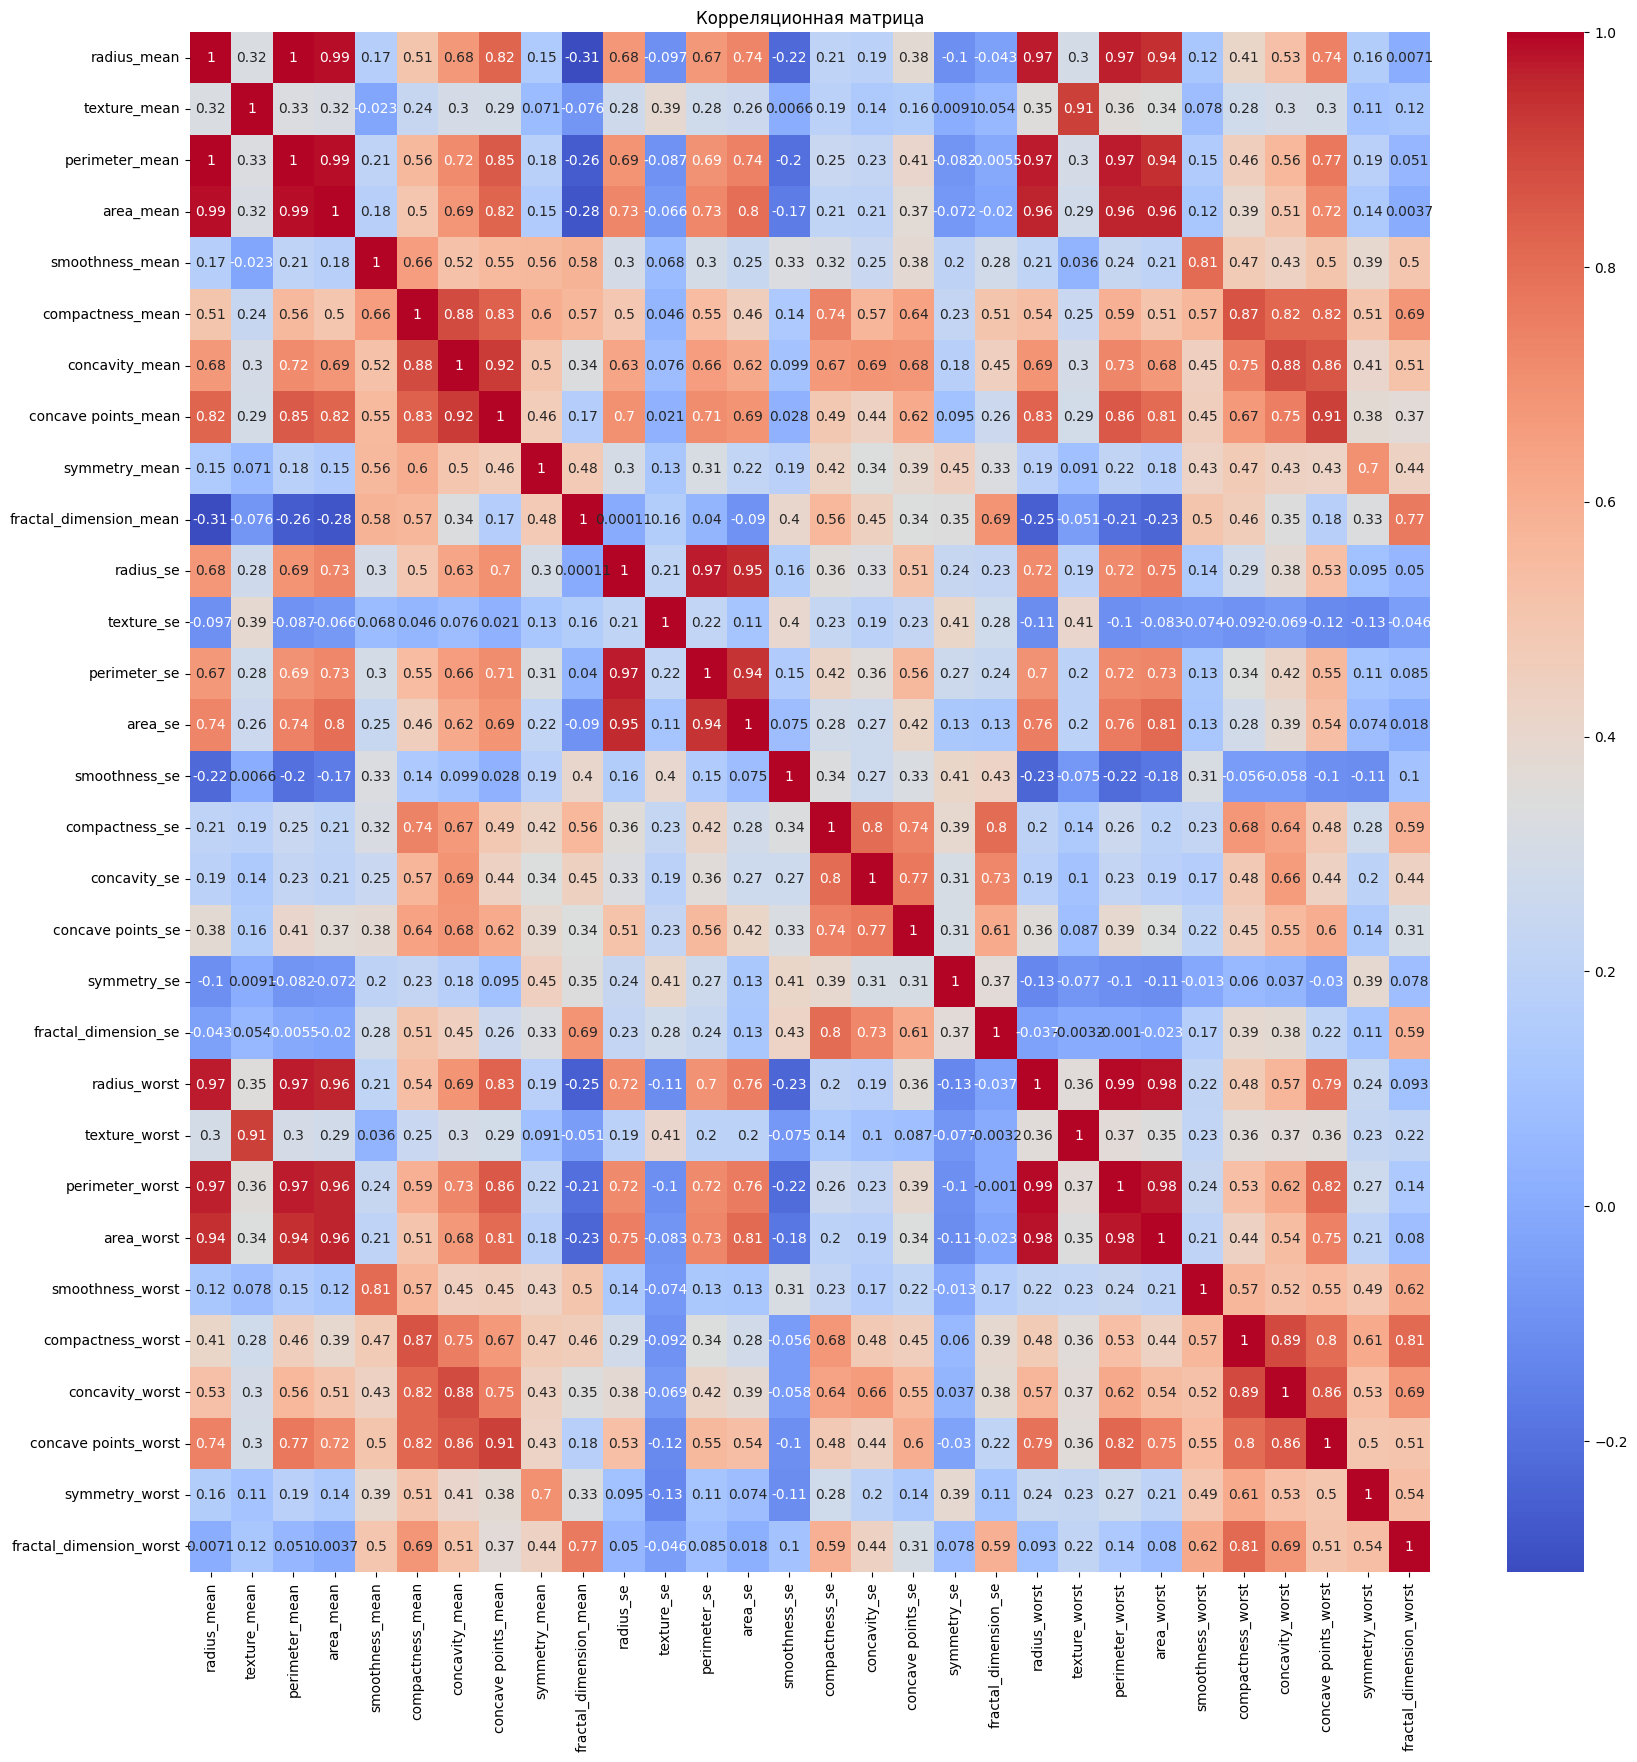

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [536]:
import seaborn as sns

correlation_matrix = df.corr()
plt.figure(figsize=(20,20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Корреляционная матрица')
plt.show()
df

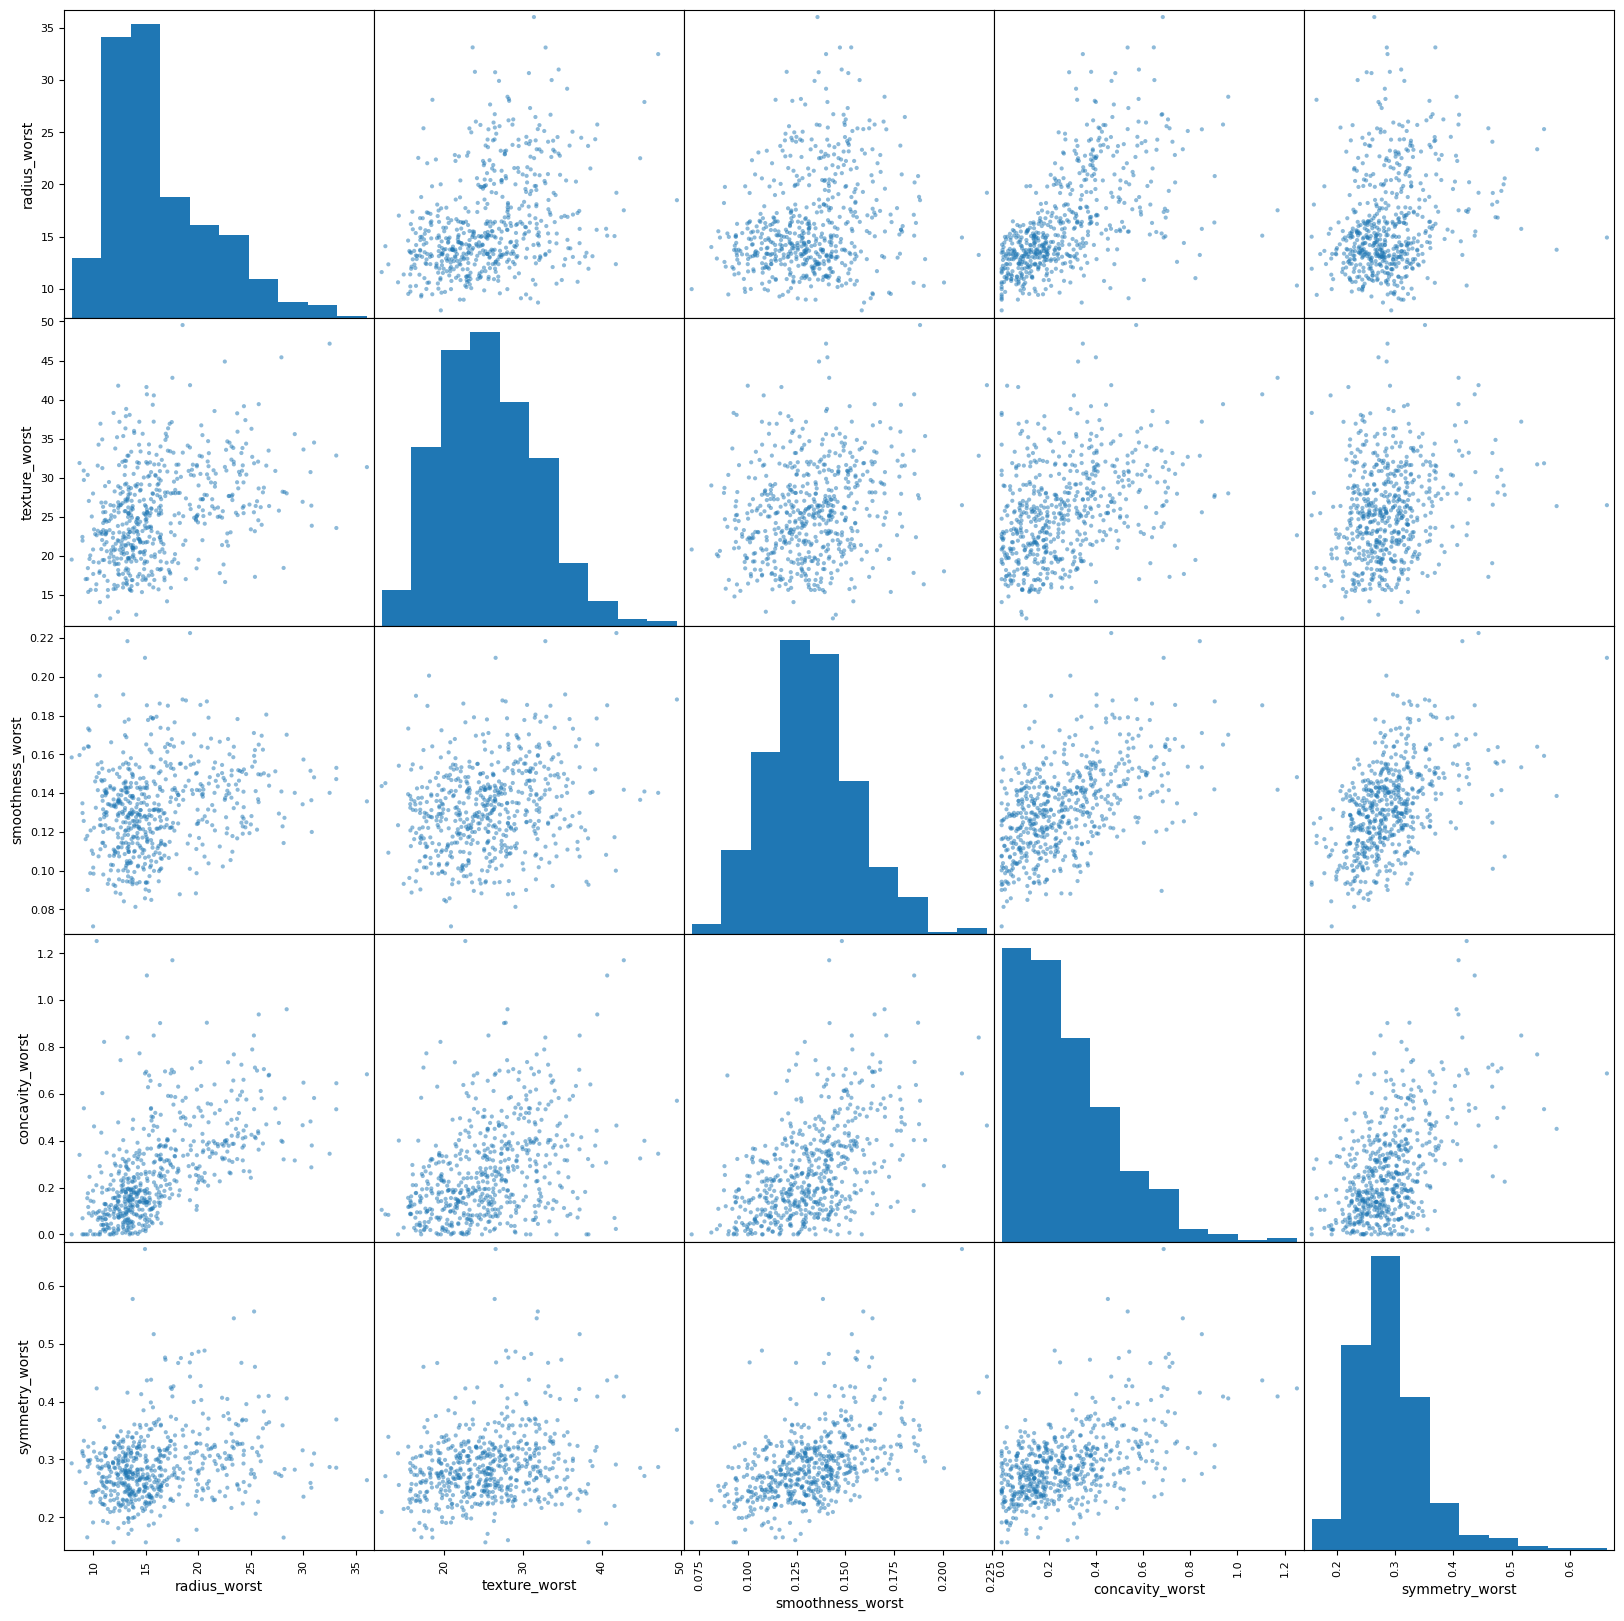

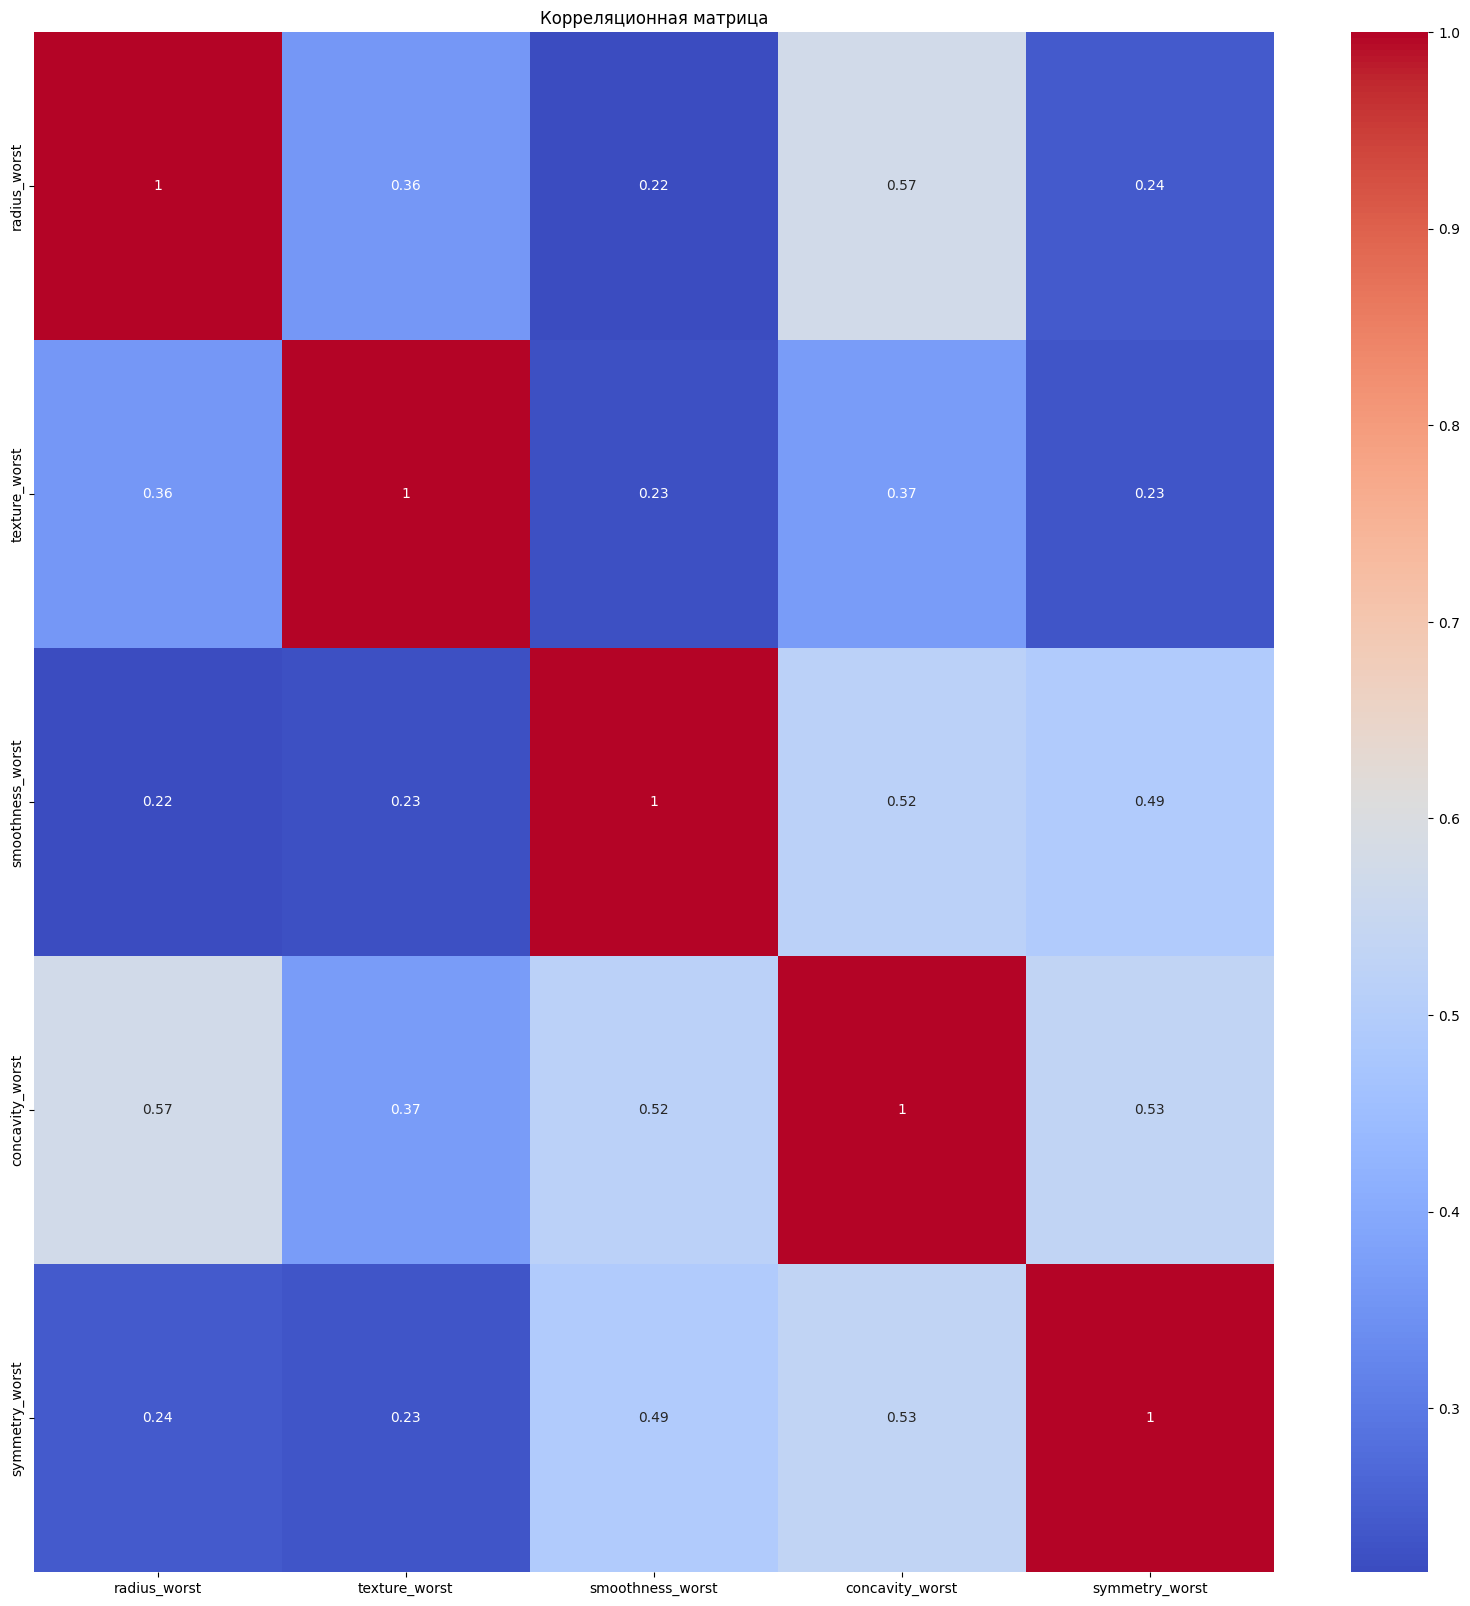

,radius_worst,texture_worst,smoothness_worst,concavity_worst,symmetry_worst
0,25.380,17.33,0.16220,0.7119,0.4601
1,24.990,23.41,0.12380,0.2416,0.2750
2,23.570,25.53,0.14440,0.4504,0.3613
3,14.910,26.50,0.20980,0.6869,0.6638
4,22.540,16.67,0.13740,0.4000,0.2364
...,...,...,...,...,...
564,25.450,26.40,0.14100,0.4107,0.2060
565,23.690,38.25,0.11660,0.3215,0.2572
566,18.980,34.12,0.11390,0.3403,0.2218
567,25.740,39.42,0.16500,0.9387,0.4087


In [537]:
df = df.iloc[:, 20:30]
#df = df.drop(columns=['perimeter_mean', 'area_mean', 'concave points_mean', 'compactness_mean', 'smoothness_mean', 'concavity_mean', 'perimeter_se', 'area_se', 'concave points_se', 'compactness_se', 'smoothness_se', 'concavity_se', 'radius_worst', 'perimeter_worst', 'area_worst', 'concave points_worst', 'compactness_worst', 'smoothness_worst', 'concavity_worst', 'texture_worst'], axis=1)
df = df.drop(columns=['perimeter_worst', 'area_worst', 'concave points_worst', 'compactness_worst', 'fractal_dimension_worst'], axis=1)

pd.plotting.scatter_matrix(df, figsize=(20, 20))
correlation_matrix = df.corr()
plt.figure(figsize=(20,20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Корреляционная матрица')
plt.show()
df

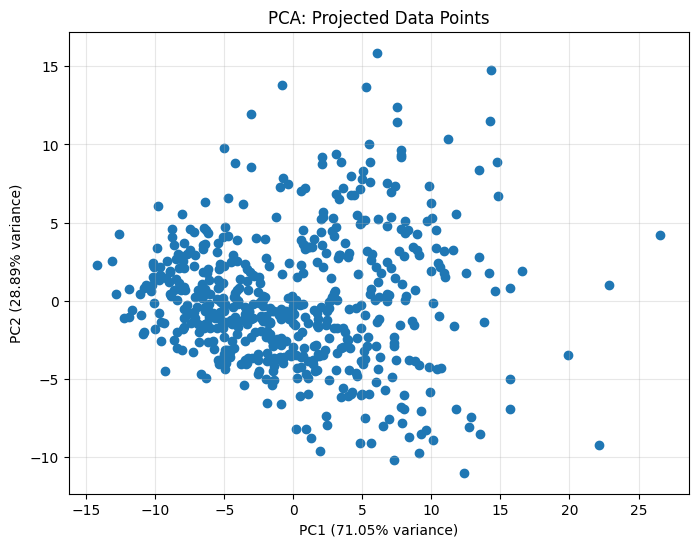

,radius_worst,texture_worst,smoothness_worst,concavity_worst,symmetry_worst
0,25.38,17.33,0.1622,0.7119,0.4601
1,24.99,23.41,0.1238,0.2416,0.2750
2,23.57,25.53,0.1444,0.4504,0.3613
3,14.91,26.50,0.2098,0.6869,0.6638
4,22.54,16.67,0.1374,0.4000,0.2364


In [538]:
import seaborn as sns

#df.describe()
#sns.pairplot(df)
#df = df.iloc[:, 0:6]
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
pca = PCA(n_components=2)
X_pca = pca.fit_transform(df)  # Store the transformed data

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1])
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.title('PCA: Projected Data Points')
plt.grid(True, alpha=0.3)
plt.show()
df.head()

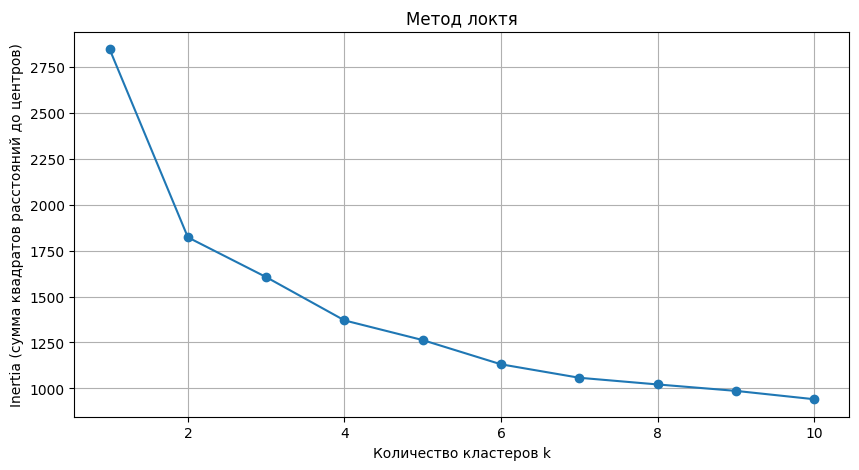

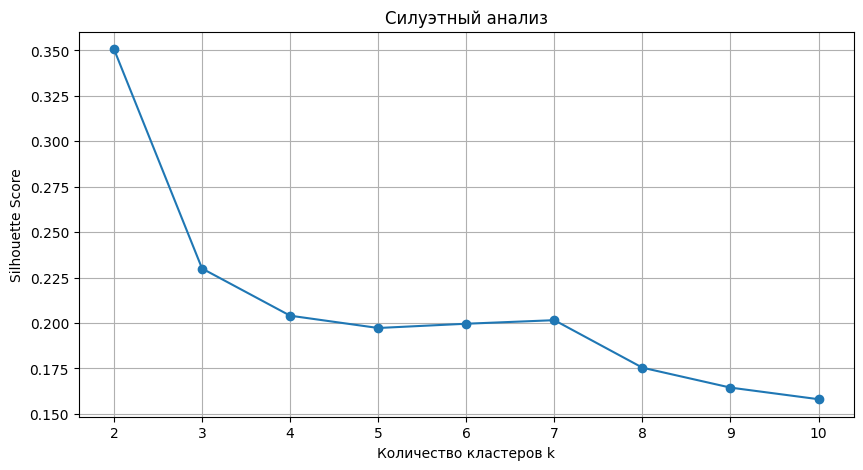

In [539]:
from sklearn.preprocessing import StandardScaler

X = df.values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
df_scaled = scaler.fit_transform(df)
from sklearn.cluster import KMeans, DBSCAN
import matplotlib.pyplot as plt

inertia = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10,5))
plt.plot(K_range, inertia, marker='o')
plt.title("Метод локтя")
plt.xlabel("Количество кластеров k")
plt.ylabel("Inertia (сумма квадратов расстояний до центров)")
plt.grid(True)
plt.show()
from sklearn.metrics import silhouette_score

silhouette_scores = []
K_range = range(2, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    sil_score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(sil_score)

plt.figure(figsize=(10,5))
plt.plot(K_range, silhouette_scores, marker='o')
plt.title("Силуэтный анализ")
plt.xlabel("Количество кластеров k")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()


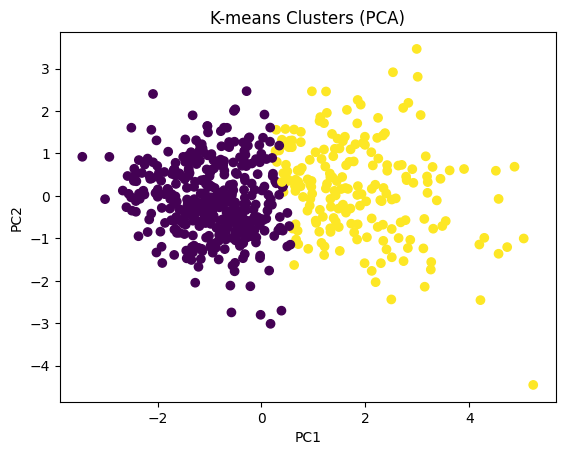

0.3506611808480728


In [540]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_pca = pca.fit_transform(df_scaled)

kmeans = KMeans(n_clusters=2, random_state=42)
labels_kmn = kmeans.fit_predict(df_scaled)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_kmn)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('K-means Clusters (PCA)')
plt.show()
from sklearn.metrics import silhouette_score, adjusted_rand_score

sil = silhouette_score(df_scaled, labels_kmn)
print(sil)


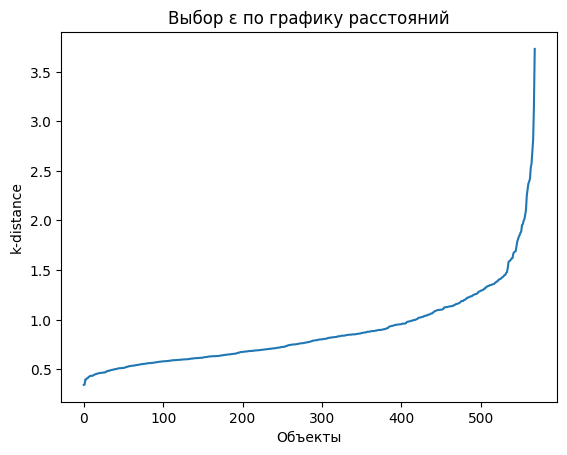

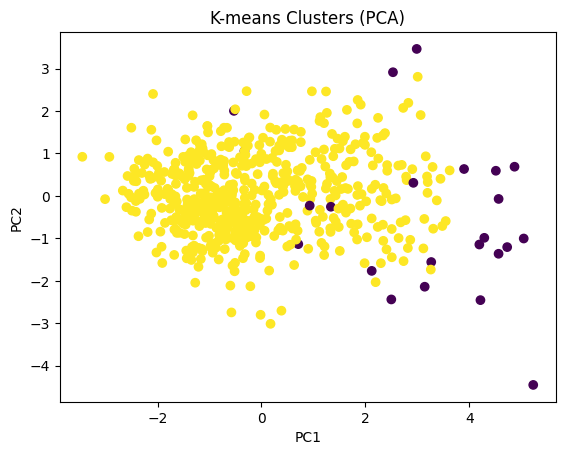

0.43227546464625655
Количество кластеров (без учета шума): 1
Количество точек, помеченных как шум: 23


In [541]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

neigh = NearestNeighbors(n_neighbors=5)
nbrs = neigh.fit(df_scaled)
distances, indices = nbrs.kneighbors(df_scaled)

distances = np.sort(distances[:, 4])
plt.plot(distances)
plt.ylabel("k-distance")
plt.xlabel("Объекты")
plt.title("Выбор ε по графику расстояний")
plt.show()

db = DBSCAN(eps=1.5, min_samples=6)
labels = db.fit_predict(df_scaled)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('K-means Clusters (PCA)')
plt.show()
from sklearn.metrics import silhouette_score, adjusted_rand_score

sil = silhouette_score(df_scaled, labels)
print(sil)
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print(f"Количество кластеров (без учета шума): {n_clusters}")

# Опционально: сколько точек шум
n_noise = list(labels).count(-1)
print(f"Количество точек, помеченных как шум: {n_noise}")

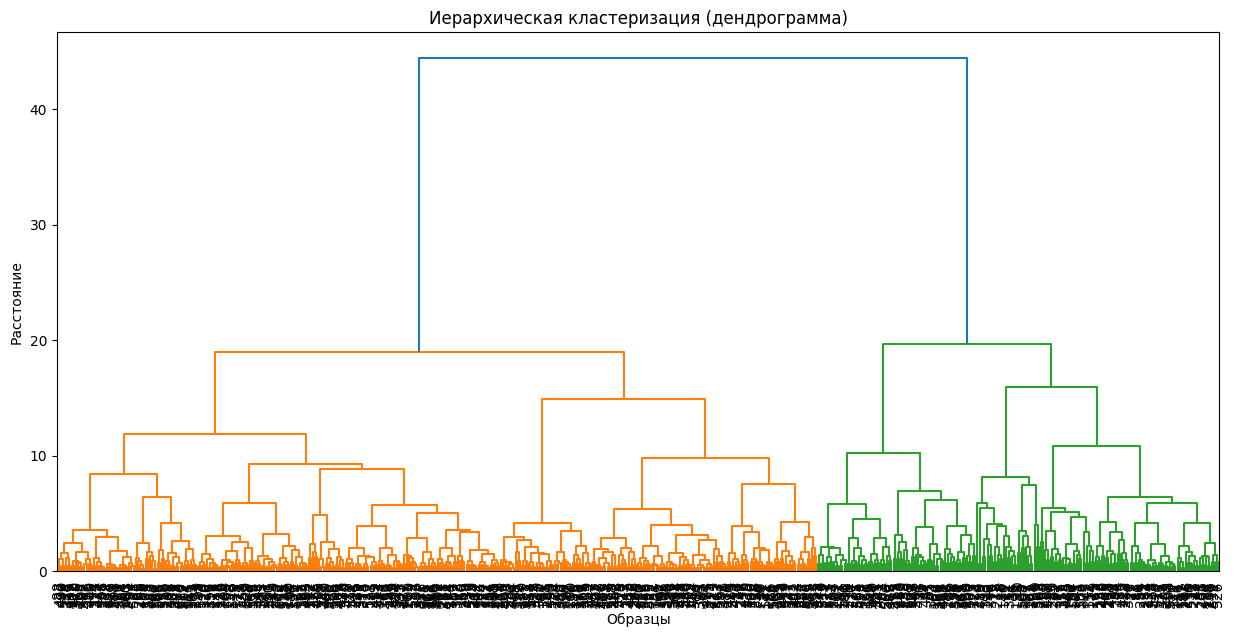

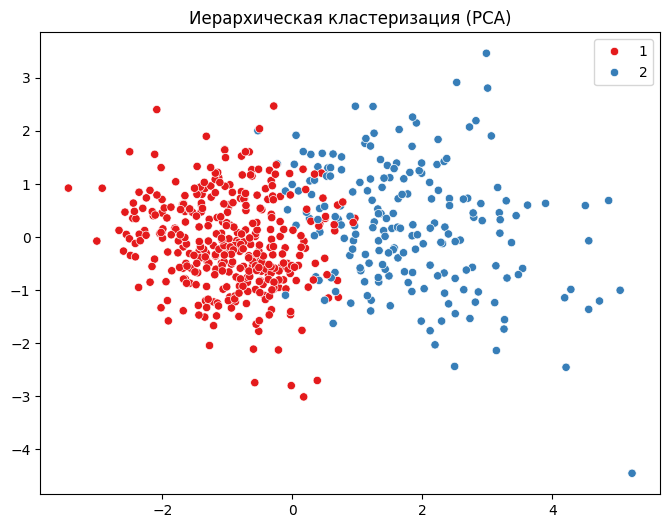

0.33967999468953824


In [542]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib.pyplot as plt
import seaborn as sns

# linkage — строим иерархию
Z = linkage(df_scaled, method='ward')  # метод Ward минимизирует внутрикластерную дисперсию

# рисуем дендрограмму
plt.figure(figsize=(15, 7))
dendrogram(Z, leaf_rotation=90, leaf_font_size=10)
plt.title('Иерархическая кластеризация (дендрограмма)')
plt.xlabel('Образцы')
plt.ylabel('Расстояние')
plt.show()

# Например, выберем k = 2
k = 2
labels_hier = fcluster(Z, k, criterion='maxclust')

# Проверим распределение по кластерам
import numpy as np
np.bincount(labels_hier)  # сколько точек в каждом кластере

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x=df_pca[:,0], y=df_pca[:,1], hue=labels_hier, palette='Set1')
plt.title('Иерархическая кластеризация (PCA)')
plt.show()

sil = silhouette_score(df_scaled, labels_hier)
print(sil)


In [543]:
# y_true — реальные классы (0/1)
from sklearn.metrics import adjusted_rand_score, jaccard_score
y_true = df_orig['diagnosis'].map({'M': 1, 'B': 0}).values
ari = adjusted_rand_score(y_true, labels_kmn)
print(f'Adjusted Rand Index: {ari:.3f}')

ari = adjusted_rand_score(y_true, labels_hier)
print(f'Adjusted Rand Index: {ari:.3f}')


Adjusted Rand Index: 0.700
Adjusted Rand Index: 0.755


In [550]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, adjusted_rand_score, jaccard_score
from scipy.spatial.distance import cdist
import pandas as pd
import numpy as np


def cluster_distances(X, labels):
    clusters = np.unique(labels)
    centroids = np.array([X[labels==c].mean(axis=0) for c in clusters])
    
    # Внутрикластерные расстояния (среднее расстояние до центра кластера)
    intra_dists = []
    for i, c in enumerate(clusters):
        intra_dists.append(np.mean(cdist(X[labels==c], [centroids[i]], metric='euclidean')))
    avg_intra = np.mean(intra_dists)
    
    # Межкластерные расстояния (между центрами)
    if len(clusters) > 1:
        inter_dists = cdist(centroids, centroids, metric='euclidean')
        # Убираем диагональ (расстояние до самого себя)
        inter_dists = inter_dists[np.triu_indices(len(clusters), k=1)]
        avg_inter = np.mean(inter_dists)
    else:
        avg_inter = np.nan
    
    return avg_intra, avg_inter, centroids

# X_scaled — стандартизированные признаки
# labels_kmeans — кластеры K-means
# labels_gmm — кластеры GMM
# y_true — истинные классы (если известны)

metrics = []

for method, labels in [('K-means', labels_kmn), ('Hierarchy', labels_hier)]:
    # Внутри- и межкластерные расстояния
    intra, inter, centroids = cluster_distances(X_scaled, labels)
    
    # Внутренние метрики
    sil = silhouette_score(X_scaled, labels)
    ch = calinski_harabasz_score(X_scaled, labels)
    
    # Внешние метрики (если известны истинные классы)
    ari = adjusted_rand_score(y_true, labels)
    jaccard = jaccard_score(y_true, labels, average='macro')  # для бинарного случая
    from sklearn.metrics import rand_score

    ri = rand_score(y_true, labels)

    metrics.append({
        'Метод': method,
        'Silhouette Score': sil,
        'Calinski-Harabasz': ch,
        'Среднее внутрикластерное расстояние': intra,
        'Среднее межкластерное расстояние': inter,
        'Adjusted Rand Index': ari,
        'Rand': ri,
        'Jaccard Index': jaccard,
        'Центры кластеров': centroids
    })

# Создаём DataFrame
metrics_df = pd.DataFrame(metrics)
metrics_df



,Метод,Silhouette Score,Calinski-Harabasz,Среднее внутрикластерное расстояние,Среднее межкластерное расстояние,Adjusted Rand Index,Rand,Jaccard Index,Центры кластеров
0,K-means,0.350661,318.458514,1.717083,2.828936,0.700356,0.851123,0.839104,"[[-0.5000348282404706, -0.3351493280607446, -0..."
1,Hierarchy,0.339680,301.774743,1.731563,2.770005,0.754938,0.878190,0.015532,"[[-0.5431471976526815, -0.30053742300003256, -..."


0.848181920522346


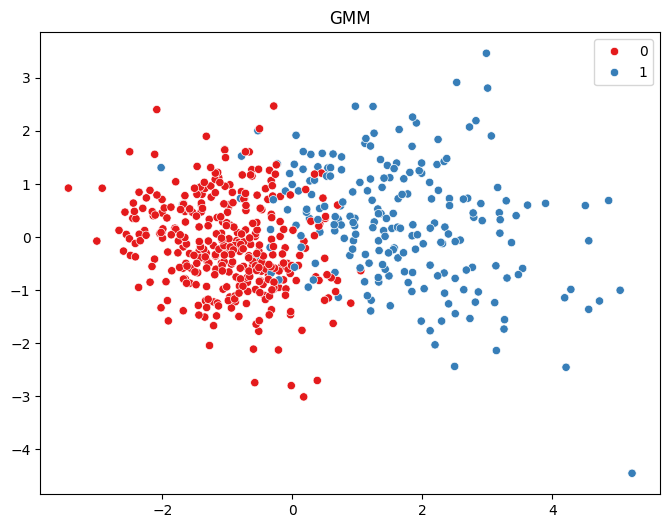

0.31988990147098506


In [554]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, adjusted_rand_score
import matplotlib.pyplot as plt
import seaborn as sns

gmm = GaussianMixture(n_components=2, random_state=42)
gmm.fit(X_scaled)
labels_gmm = gmm.predict(X_scaled)

print(jaccard_score(y_true, labels_gmm, average='macro'))

pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x=df_pca[:,0], y=df_pca[:,1], hue=labels_gmm, palette='Set1')
plt.title('GMM')
plt.show()

sil = silhouette_score(df_scaled, labels_gmm)
print(sil)